In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as tfhub
import efficientnet.tfkeras as efn

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
net = efn.EfficientNetB7()
net.summary()

   630784/268317848 [..............................] - ETA: 1:58:35

KeyboardInterrupt: 

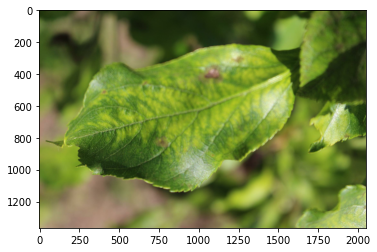

(1365, 2048, 3)


In [2]:
def read_image(file):
    raw = tf.io.read_file(file)
    image = tf.io.decode_jpeg(raw)
    return image


train_image = read_image('./images/Train_0.jpg')

plt.imshow(train_image)
plt.show()

print(train_image.shape)

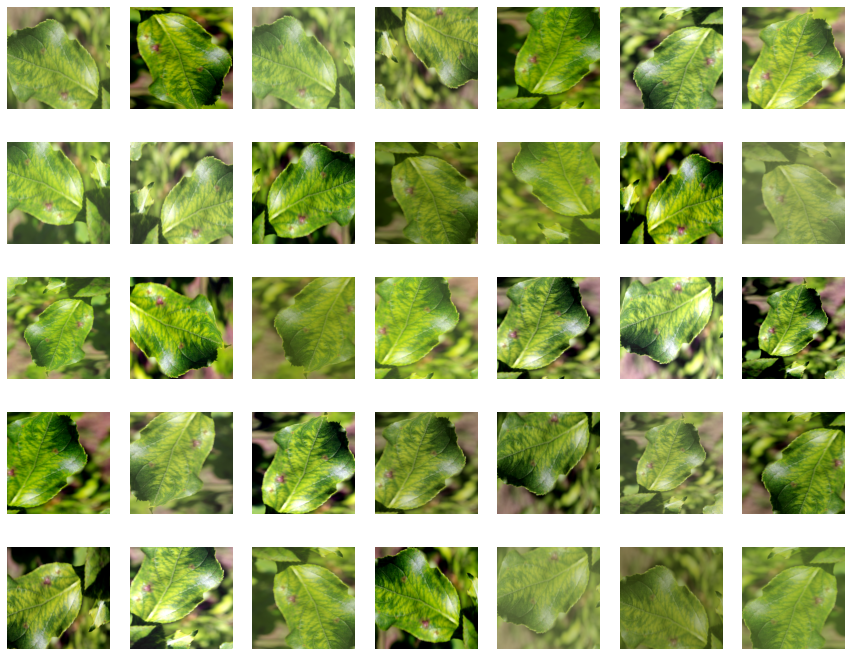

In [3]:
INPUT_SIZE = (512, 512)

def normalize(image):
    return tf.cast(image, tf.float32) / 255.0


def random_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image


def random_crop(image):
    image = tf.image.resize(image, [512, 340], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, [375, 250, 3])
    return image


@tf.function
def random_rotate(image):
    p = tf.random.uniform((), 0, 1.0)
    if p < 0.25:
        image = tf.image.rot90(image, 1)
    elif p < 0.5:
        image = tf.image.rot90(image, 2)
    elif p < 0.75:
        image = tf.image.rot90(image, 3)
    return image


def random_jitter(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_contrast(image, 0.5, 1.6)
    image = tf.image.random_saturation(image, 0.8, 1.3)
    image = tf.image.random_brightness(image, 30)
    image = tf.clip_by_value(image, 0, 255)
    return image


@tf.function
def random_process(image):
    image = random_flip(image)
    if tf.random.uniform((), 0, 1.0) > 0.1:
        image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_rotate(image)
    image = random_jitter(image)
    return normalize(image)


plt.figure(figsize=(15, 12))
for n in range(35):
    test_image = random_process(train_image)
    plt.subplot(5, 7, n+1)
    plt.imshow(test_image)
    plt.axis('off')

plt.show()

In [4]:
def get_noisy_student_data(csv):
    csv = pd.read_csv(csv)
    images = []
    labels = []
    for row in csv.values:
        images.append('./images/' + row[0] + '.jpg')
        one_hot = np.zeros_like(row[1:])
        one_hot[np.argmax(row[1:])] = 1
        labels.append(one_hot)
        assert np.max(labels[-1]) == 1.0
        assert np.argmax(labels[-1]) == np.argmax(row[1:])
    assert len(images) == len(labels)
    noisy_student = tf.data.Dataset.from_tensor_slices((images, labels))
    return noisy_student

print(glob('./others/*.csv'))
student1 = get_noisy_student_data('./others/submission_efnns.csv')
student2 = get_noisy_student_data('./others/submission_efn.csv')
student3 = get_noisy_student_data('./others/submission_ensemble_3.csv')
student4 = get_noisy_student_data('./others/submission_ensemble_1.csv')
student5 = get_noisy_student_data('./others/submission_ensemble_2.csv')

print(student1)
print(student2)
print(student3)
print(student4)
print(student5)

noisy_student = student1.concatenate(student2).concatenate(student3).concatenate(student4).concatenate(student5)
print(noisy_student)

['./others/submission_efnns.csv', './others/submission_efn.csv', './others/submission_ensemble_3.csv', './others/submission_ensemble_1.csv', './others/submission.csv', './others/submission_ensemble_2.csv', './others/submission_dnn.csv']
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>
<ConcatenateDataset shapes: ((), (4,)), types: (tf.string, tf.int32)>


In [13]:
def get_train_valid_split(csv, train_percent=0.85):
    csv = pd.read_csv(csv)
    images = []
    labels = []
    for row in csv.values:
        images.append('./images/' + row[0] + '.jpg')
        labels.append(row[1:])
    assert len(images) == len(labels)
    
    pair = [(images[i], labels[i]) for i in range(len(images))]
    np.random.shuffle(pair)
    
    train_size = int(len(images) * train_percent)
    train_images = [p[0] for p in pair[:train_size]]
    train_labels = [p[1] for p in pair[:train_size]]
    valid_images = [p[0] for p in pair[train_size:]]
    valid_labels = [p[1] for p in pair[train_size:]]
    
    print('train size: ', len(train_images))
    print('valid size: ', len(valid_images))
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
    return train_ds, valid_ds


def train_pipeline(image_path, label):
    image = read_image(image_path)
    image = random_process(image)
    return image, label


def valid_pipeline(image_path, label):
    image = read_image(image_path)
    image = tf.image.resize(image, INPUT_SIZE)
    image = normalize(image)
    return image, label


train_ds, valid_ds = get_train_valid_split('./train.csv')
# train_ds = train_ds.concatenate(noisy_student.shuffle(10000).take(100))

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(2)
valid_ds = valid_ds.shuffle(100).batch(2)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>


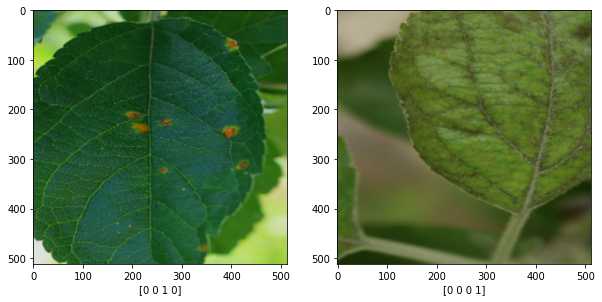

In [14]:
train_iter = iter(train_ds)
train_image_batch, train_label_batch = next(train_iter)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(train_image_batch[i])
    plt.xlabel(str(train_label_batch[i].numpy()))
plt.show()

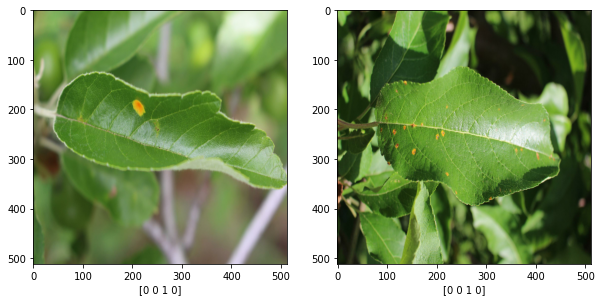

In [15]:
valid_iter = iter(valid_ds)
valid_image_batch, valid_label_batch = next(valid_iter)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(valid_image_batch[i])
    plt.xlabel(str(valid_label_batch[i].numpy()))
plt.show()

# Model1: EfficientNet-B6

In [16]:
def build_model1():
    model = keras.Sequential([
        efn.EfficientNetB6(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='imagenet',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model


keras.backend.clear_session()
model1 = build_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 40,969,356
Trainable params: 40,744,924
Non-trainable params: 224,432
_________________________________________________________________


In [17]:
model1.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='categorical_crossentropy',
               metrics=['categorical_accuracy'])

In [18]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 1e-4
    elif epoch == 40:
        return 2.5e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

In [19]:
history = model1.fit(train_ds,
                     epochs=60,
                     validation_data=valid_ds,
                     callbacks=[lr_scheduler, tensorboard_callback])

Train for 774 steps, validate for 137 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/60
774/774 [==============================] - 260s 336ms/step - loss: 1.0768 - categorical_accuracy: 0.5785 - val_loss: 0.9869 - val_categorical_accuracy: 0.5511

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/60
774/774 [==============================] - 240s 310ms/step - loss: 0.8160 - categorical_accuracy: 0.7085 - val_loss: 0.6900 - val_categorical_accuracy: 0.7372

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/60
774/774 [==============================] - 239s 309ms/step - loss: 0.5659 - categorical_accuracy: 0.8106 - val_loss: 0.9534 - val_categorical_accuracy: 0.6825

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/60
774/774 [==============================] - 239s 309ms/step - loss: 0.4759 - categorical_accurac


Epoch 00033: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 33/60
774/774 [==============================] - 238s 308ms/step - loss: 0.1546 - categorical_accuracy: 0.9548 - val_loss: 0.5092 - val_categorical_accuracy: 0.9088

Epoch 00034: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 34/60
774/774 [==============================] - 239s 309ms/step - loss: 0.1158 - categorical_accuracy: 0.9599 - val_loss: 0.3063 - val_categorical_accuracy: 0.9197

Epoch 00035: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 35/60
774/774 [==============================] - 240s 310ms/step - loss: 0.1250 - categorical_accuracy: 0.9625 - val_loss: 0.5083 - val_categorical_accuracy: 0.9088

Epoch 00036: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 36/60
774/774 [==============================] - 240s 310ms/step - loss: 0.1203 - categorical_accuracy: 0.9625 - val_loss: 0.6806 - val_categ

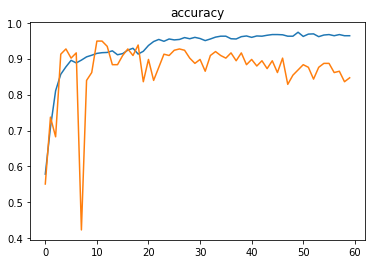

In [20]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('accuracy')
plt.show()

In [21]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/efficientnetb6.checkpoint')

'../../checkpoint/plant-pathology/efficientnetb6.checkpoint-1'

In [27]:
checkpoint = tf.train.Checkpoint()
if os.path.isdir('../../checkpoint/plant-pathology/'):
    print('restoring checkpoint...')
    checkpoint.restore('../../checkpoint/plant-pathology/baseline.checkpoint-2')

restoring checkpoint...


In [23]:
def submission(output_name):
    csv = pd.read_csv('./sample_submission.csv')
    for i in range(len(csv)):
        row = csv.iloc[i]
        image = read_image('./images/' + row[0] + '.jpg')
        image = tf.image.resize(image, INPUT_SIZE)
        image = image[tf.newaxis, ...]
        image = normalize(image)
        results = model1.predict(image)
        csv.iloc[i, 1:] = results[0]
        print('\rprocessed: %d/%d' % (i+1, len(csv)), end='')
    print()
    csv.to_csv(output_name, index=False)
    print(csv.head())


submission('efficientnet-b6-results.csv')

processed: 1821/1821
  image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.000002       8.171092e-03  9.918272e-01  2.553299e-08
1   Test_1  0.997550       2.186056e-11  2.449776e-03  6.109189e-25
2   Test_2  0.000134       1.514259e-02  7.883878e-07  9.847222e-01
3   Test_3  0.998004       9.187173e-04  9.748157e-04  1.022755e-04
4   Test_4  0.267538       1.202066e-02  7.204406e-01  1.308118e-06


# Model2: EfficientNet-B7

In [ ]:
# reload train/valid datasets
train_ds, valid_ds = get_train_valid_split('./train.csv')
train_ds = train_ds.concatenate(noisy_student.shuffle(10000).take(100))

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(2)
valid_ds = valid_ds.shuffle(100).batch(2)

In [ ]:
def build_model2():
    model = keras.Sequential([
        efn.EfficientNetB7(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='imagenet',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model


keras.backend.clear_session()
model2 = build_model2()
model2.summary()

In [ ]:
model2.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='categorical_crossentropy',
               metrics=['categorical_accuracy'])

In [ ]:
history = model2.fit(train_ds,
                     epochs=60,
                     validation_data=valid_ds,
                     callbacks=[lr_scheduler, tensorboard_callback])